# Assignment 3
Denise Neuman dn9264<br>
Aishwarya Sarkar (as99646) <br>
Varun Kausika vsk394

In [57]:
import pandas as pd
import re
import copy

### Q1) Read in data

In [58]:
gold = pd.read_csv('gold.txt', dtype = str, header=None) # Read the gold.txt file
labels = pd.read_csv('labels.txt', dtype = str, header=None) # Read the labels.txt file

# Function to get the last character of the URL to create a new Category column
def splitLast(url):
    return url.rsplit()[-1]
gold['category'] = gold[gold.columns[0]].map(splitLast) # Create Category column in gold DF
labels['category'] = labels[labels.columns[0]].map(splitLast) # Create Category column in lables DF

# Function to separate URL from category
def removeLast(url):
    return url[:-1].rstrip('\t')
gold[gold.columns[0]] = gold[gold.columns[0]].map(removeLast) # Create URL column
labels[labels.columns[0]] = labels[labels.columns[0]].map(removeLast) # Create turk and URL column

# Function to get the URL with no Turk 
def splitURL(line):
    return line.rsplit('\t')[-1]
labels['url'] = labels[labels.columns[0]].map(splitURL) # Create URL column

# Function to separate turk from URL
def removeURL(line):
    return line.split('\t')[0]
labels[labels.columns[0]] = labels[labels.columns[0]].map(removeURL) # Create Category column

gold = gold.rename(columns={gold.columns[0]: 'url'}) # Rename the first column of gold as 'url'
labels = labels.rename(columns={labels.columns[0]: 'turk'}) # Rename the first column of labels as 'turk'
labels = labels[['turk', 'url', 'category']] # Reorganize labels DataFrame, so columns are in the correct order

print(gold) # Gold DataFrame ready
print(labels) # Labels DataFrame ready

                                         url category
0                  http://0800-horoscope.com        G
1                         http://18games.net        X
2                       http://1pixelout.net        G
3     http://1porno.com/004/teens/index.html        X
4      http://1stpussy.com/005/16/index.html        X
...                                      ...      ...
1512                     http://zipcodez.com        G
1513                          http://zml.com        P
1514                     http://zonezero.com        G
1515                       http://zooped.com        R
1516                        http://ztrua.com        G

[1517 rows x 2 columns]
                 turk               url category
0      A1OT3A29R9N1DG     http://000.cc        P
1      A1PXXEOGQ76RNJ     http://000.cc        G
2      A1PXXEOGQ76RNJ     http://000.cc        G
3      A21US576U8SCO4     http://000.cc        G
4      A2LGX47NN7C5D3     http://000.cc        G
...               ...            

### Q2) Split into two DataFrames

In [59]:
# Inner join of labels and gold DataFrames to create labels_on_gold DF
labels_on_gold = labels.merge(gold,
                                 left_on = ['url'],
                                 right_on = ['url'],
                                 suffixes=['_l', '_g'])

# Outer join of labels and gold DataFrames and create new column that creates a column with indicator of rows that
# only appear in labels to create outer_join DF
# The following StackOverflow question was used to answer this part:
# https://stackoverflow.com/questions/50543326/how-to-do-left-outer-join-exclusion-in-pandas
outer_join = labels.merge(gold,
                             left_on = ['url'],
                             right_on = ['url'],
                             suffixes=['_l', '_g'],
                             how = 'outer', indicator=True
              ).query('_merge=="left_only"')

# Create labels_unknown DF by selecting the rows with "left only" and dropping the _merge column
labels_unknown = outer_join[outer_join['_merge'] == "left_only"].drop('_merge', axis=1)

print(labels_on_gold)
print(labels_unknown)

                turk                        url category_l category_g
0     A1253FXHCZ9CWM  http://0800-horoscope.com          G          G
1     A153PKAL7OAY36  http://0800-horoscope.com          G          G
2     A1FV9SAPL5C6KY  http://0800-horoscope.com          G          G
3     A1JTOT0DWM6QGL  http://0800-horoscope.com          G          G
4     A1PXXEOGQ76RNJ  http://0800-horoscope.com          G          G
...              ...                        ...        ...        ...
3319  A35CBDDGBM7T6E       http://yousendit.com          G          G
3320  A3J86MK3VIE6ST       http://yousendit.com          G          G
3321   A4GP97LAQCCHJ       http://yousendit.com          G          G
3322   AAQNUEUU7H1Y5       http://yousendit.com          G          G
3323   ANC9EWZTGN5HK       http://yousendit.com          G          G

[3324 rows x 4 columns]
                 turk               url category_l category_g
0      A1OT3A29R9N1DG     http://000.cc          P        NaN
1      A1PX

### Q3) Compute accuracies of turks

In [60]:
# Create mask for correct ratings
maskCorrect = (labels_on_gold['category_l'] == labels_on_gold['category_g'])

# Create Boolean column for correct ratings
labels_on_gold['correct'] = maskCorrect.astype('int') 

# Group By. Create grups of turks, with the count of the ratings and the number of the correct ratings
turkGroups = labels_on_gold.groupby('turk')[['url', 'correct']].agg({'url': ['count'], 'correct': ['sum']})

# Create new column with average correctness
turkGroups['avgCorrectness'] = turkGroups['correct', 'sum'] / turkGroups['url', 'count']

# Remove multi-index of columns, dropping the subindex[1]
# To drop the subindex[1] the following StackOverflow link was used:
# https://stackoverflow.com/questions/22233488/pandas-drop-a-level-from-a-multi-level-column-index
rater_goodness = pd.DataFrame(turkGroups)
rater_goodness.columns = rater_goodness.columns.droplevel(1)

# Rename columns
rater_goodness = rater_goodness.rename(columns={rater_goodness.columns[0]: 'ratingsCount', rater_goodness.columns[1]: 'ratingsCorrect'})

# Drop the column of correct ratings
rater_goodness = rater_goodness.drop(columns='ratingsCorrect', axis=1)

rater_goodness

,ratingsCount,avgCorrectness
turk,,
A112DVP1KG4QZU,1,1.000000
A1253FXHCZ9CWM,29,0.517241
A12CY1Q7XKJJDE,1,1.000000
A12RE8G66WTO8B,20,0.750000
A12Y1GTGIQDGRA,3,0.333333
...,...,...
AYWOBMTEGFVVI,1,0.000000
AZ1S5BIG5R6P6,35,0.714286
AZSDW7JJL5VA7,100,0.680000


### Q4) Odds ratios

In [61]:
# Create the column with the calculated odds
rater_goodness['odds'] = rater_goodness['avgCorrectness'] / (1.001 - rater_goodness['avgCorrectness'])
rater_goodness

,ratingsCount,avgCorrectness,odds
turk,,,
A112DVP1KG4QZU,1,1.000000,1000.000000
A1253FXHCZ9CWM,29,0.517241,1.069214
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251
...,...,...,...
AYWOBMTEGFVVI,1,0.000000,0.000000
AZ1S5BIG5R6P6,35,0.714286,2.491281
AZSDW7JJL5VA7,100,0.680000,2.118380


### Q5) Most accurate turks

In [62]:
# Create mask of turks who have rated more than 20 URLs
maskAtLeast20 = (rater_goodness['ratingsCount'] >= 20)

# DataFrame of turks who have rated more than 20 URLs, ordered by odds (only first 20 results)
ratersAtLeast20 = rater_goodness[maskAtLeast20]
ratersAtLeast20.sort_values(by='odds', ascending=False)[:10]

,ratingsCount,avgCorrectness,odds
turk,,,
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A32W20KGQXS0LL,25,0.800000,3.980100
A20PWAB7G3HDHU,20,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635


### Q6) Rating counts versus accuracy

In [63]:
# Q6 FIRST ARGUMENT
# Only using the raters with more than 20 ratings in order to ensure raters who have odds = 1000 (with only one rating) are not considered.
mostRatings = ratersAtLeast20.sort_values(by='ratingsCount', ascending=False)[:20]
leastRatings = ratersAtLeast20.sort_values(by='ratingsCount')[:20]

# Function to get the mean of a column
def getMean(columnName):
    return columnName.mean()
    
# Getting the mean of each column for both data sets
mostRatingsStats = mostRatings.apply(getMean)
leastRatingsStats = leastRatings.apply(getMean)

# Create new DataFrame for easy comparison
pd.DataFrame([mostRatingsStats]) # Create df with Most Ratings
dfComparison = pd.DataFrame([mostRatingsStats]).T.iloc[0:3] # Transpose DataFrame
dfComparison = dfComparison.rename(columns={dfComparison.columns[0]: 'Most Ratings Stats'}) # Rename column
dfComparison['Least Ratings Stats'] = leastRatingsStats # Add column for Least Ratings

dfComparison['Percentage Change'] = ((dfComparison['Least Ratings Stats']*100)/dfComparison['Most Ratings Stats'])-100

dfComparison

,Most Ratings Stats,Least Ratings Stats,Percentage Change
ratingsCount,81.400000,22.900000,-71.867322
avgCorrectness,0.644761,0.712192,10.458282
odds,2.258874,3.573429,58.195128


##### 1st Obsrvation
The evidence suggest that the turks with less ratings have rated (on average) 71.91% less URLs than the turks who have rated the most URLs. However, the average correctness of these "Least Number of Ratings" turks is almost 10% more correct than those who have rated more URLs. This means that the odds of the turks with less ratings of gettinng a correct rating is 54.92% higher, than those with more ratings.
The findings support the evidence that only the spammers who have the time to rate lots of URLs.
Moreover, we'll peerform a linear regression and scatterplot to confirm this hypothesis.


Text(0, 0.5, 'Average fraction of URLs rated correctly')

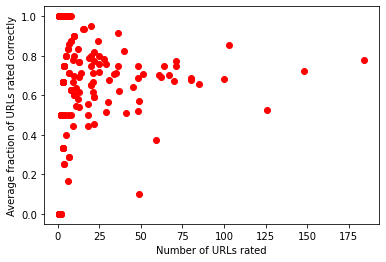

In [64]:
# Q6 SECOND ARGUMENT
import matplotlib.pyplot as plt
# Plot scatterplot
plt.plot(rater_goodness['ratingsCount'], rater_goodness['avgCorrectness'], 'ro')
plt.xlabel('Number of URLs rated') # Set X axis label
plt.ylabel('Average fraction of URLs rated correctly') # Set Y axis label

##### 2nd Obsrvation
From the graph, it seems there are very few "spammers" in this dataset, since the people who have rated a very high number of URLs have relatively high fraction of URLs rated correctly. Considering that there are 4 categories to choose from, it would be very hard to guess the correct rating for such a high number of URLs. On the other hand, for the turks who have rated very few urls, There is very high variance in the average correct fraction. However, around 30 URLs, the value seems to stabilize around 0.7 with considerably low variation.

In [65]:
# Q6 THIRD ARGUMENT
import statsmodels.api as sm
from patsy import dmatrices 
# Perform Linear Regression
y, X=dmatrices('avgCorrectness~ratingsCount',data= rater_goodness,return_type='dataframe')
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         avgCorrectness   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5488
Date:                Wed, 03 Aug 2022   Prob (F-statistic):              0.459
Time:                        15:15:07   Log-Likelihood:                -94.663
No. Observations:                 269   AIC:                             193.3
Df Residuals:                     267   BIC:                             200.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.6431      0.024     27.071      0.000       0.596       0.690
ratingsCount     0.0007      0.001      0.741      0.459      -0.001       0.002
==============================================================================
Omnibus:                       29.253   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.396
Skew:                          -0.731   Prob(JB):                     6.82e-07
Kurtosis:                       2.373   Cond. No.                         30.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Conclusion
Even though the first argument showed there was a relationship between the number of URLs rated and the average correctness, building a regression model, we see that the coefficient for the ratingsCount is very close to 0. So ratingsCount does not seem to have a significant impact on the average correctness of ratings. Morover, 0 lies inside the confidence interval. So we can conclude that, ratingsCount does not significantly impact average correctness of ratings.

### Q7) Overall predicted odds

In [66]:
# Create new DF merging labels_unknown with rater_goodness to get the odds of each turk
unknownWithOdds = labels_unknown.merge(rater_goodness,
                                            left_on = ['turk'],
                                            right_on = ['turk'],
                                            suffixes=['_LU', '_RG'],
                                            how = 'left'
                                      )

# Sort all raters from the rater_goodness DF by the number of Ratings they have done in descending order
# Get the first 25% of the DF (by using the 0.25 of the length of the DF)
minRatings = rater_goodness['ratingsCount'].quantile(0.75)
maskMinRatings = rater_goodness['ratingsCount'] > minRatings
top25Raters = rater_goodness[maskMinRatings].sort_values(by='ratingsCount', ascending=False)

# Function to get only the raters who are in the top 25%
def in_top25(turk):
    return turk in top25Raters['ratingsCount']

# Get the DF containing only the turks who are in the top 25% numbers of gold ratings  
unknownWithOdds = unknownWithOdds[unknownWithOdds['turk'].map(in_top25)]

# Group By URL and category and generating the product of the odds of each turk in who rated a URL with a specific category
urlGroups = unknownWithOdds.groupby(['url', 'category_l'])[['odds']].agg({'odds': ['prod']})

# Drop multi-indexes
urlGroups.columns = urlGroups.columns.droplevel(1)

# Rename columns
urlGroups = urlGroups.rename(columns={urlGroups.columns[0]: 'overall_odds'})

urlGroups.reset_index()

,url,category_l,overall_odds
0,http://0-101.net,G,2.155963
1,http://000.cc,G,1.460583
2,http://0000.jp,G,14.488244
3,http://000relationships.com,G,5.681060
4,http://000relationships.com,P,1.851852
...,...,...,...
13978,http://zynga.com,G,3.704611
13979,http://zz868.com,G,1.047852
13980,http://zz868.com,P,1.851852
13981,http://zzx.cc,G,1.330229


### Q8) Predicted categories

In [67]:
# Create copy of urlGroups
result_75 = urlGroups.copy()

# Unstack the caregories and drop the multi-index
result_75 = result_75.unstack('category_l')
result_75.columns = result_75.columns.droplevel(0)

# Function to get the index of the maximum value of the column
def categoryMax(url):
    return url.idxmax()

# Transpose the matrix so the columns are the URL and the indexes are the categories.
# Apply the max function to find the maximum value (category) for each column (URL)
# Apply the categoryMax function to find the index of the maximum value (category) for each column (URL)
# Get two series with index = URL as a result
maxOdds = result_75.T.apply(max)
maxCateg = result_75.T.apply(categoryMax)

# Create new columns for maximum odds and categories for each URL
result_75['top category'] = maxCateg
result_75['top odds'] = maxOdds

# Drop G, P, R and X columns
result_75 = result_75.drop(columns=['G', 'P', 'R', 'X'])
result_75

category_l,top category,top odds
url,,
http://0-101.net,G,2.155963
http://000.cc,G,1.460583
http://0000.jp,G,14.488244
http://000relationships.com,G,5.681060
http://000vitamins.com,G,3.784982
...,...,...
http://zwinky.com,G,16.141443
http://zylom.com,G,1.735526
http://zynga.com,G,3.704611


### Q9) Predicted categories using more turks

In [68]:
################# Q7 CODE #################

# Create new DF merging labels_unknown with rater_goodness to get the odds of each turk
unknownWithOdds2 = labels_unknown.merge(rater_goodness,
                                            left_on = ['turk'],
                                            right_on = ['turk'],
                                            suffixes=['_LU', '_RG'],
                                            how = 'left'
                                      )

# Sort all raters from the rater_goodness DF by the number of Ratings they have done in descending order
# Get the first 75% of the DF (by using the 0.75 of the length of the DF)
minRatings = rater_goodness['ratingsCount'].quantile(0.25)
maskMinRatings = rater_goodness['ratingsCount'] > minRatings
top75Raters = rater_goodness[maskMinRatings].sort_values(by='ratingsCount', ascending=False)

# Function to get only the raters who are in the top 75%
def in_top75(turk):
    return turk in top75Raters['ratingsCount']

# Get the DF containing only the turks who are in the top 25% numbers of gold ratings  
unknownWithOdds2 = unknownWithOdds2[unknownWithOdds2['turk'].map(in_top75)]

# Group By URL and category and generating the product of the odds of each turk in who rated a URL with a specific category
urlGroups2 = unknownWithOdds2.groupby(['url', 'category_l'])[['odds']].agg({'odds': ['prod']})

# Drop multi-indexes
urlGroups2.columns = urlGroups2.columns.droplevel(1)

# Rename columns
urlGroups2 = urlGroups2.rename(columns={urlGroups2.columns[0]: 'overall_odds'})

################# Q8 CODE #################

# Create copy of urlGroupsS
result_25 = urlGroups2.copy()

# Unstack the caregories and drop the multi-index
result_25 = result_25.unstack('category_l')
result_25.columns = result_25.columns.droplevel(0)

# Function to get the index of the maximum value of the column
def categoryMax(url):
    return url.idxmax()

# Transpose the matrix so the columns are the URL and the indexes are the categories.
# Apply the max function to find the maximum value (category) for each column (URL)
# Apply the categoryMax function to find the index of the maximum value (category) for each column (URL)
# Get two series with index = URL as a result
maxOdds2 = result_25.T.apply(max)
maxCateg2 = result_25.T.apply(categoryMax)

# Create new columns for maximum odds and categories for each URL
result_25['top category'] = maxCateg2
result_25['top odds'] = maxOdds2

# Drop G, P, R and X columns
result_25 = result_25.drop(columns=['G', 'P', 'R', 'X'])

################# Q9 NEW CODE #################

# Use the crosstab function to create a table where index and columns are the categories, and cells are number of urls with these as the top categories in result 75 and result 25
comparison = pd.crosstab(result_75['top category'], result_25['top category'], margins=True)

# Rename axis and rename axis of columns
comparison = comparison.rename_axis('Results 25%', axis='columns').rename_axis('Results 75%')
comparison

Results 25%,G,P,R,X,All
Results 75%,,,,,
G,8327,574,186,216,9303
P,189,328,47,19,583
R,21,34,128,25,208
X,27,6,26,457,516
All,8564,942,387,717,10610


##### Conclusion
The most errors occur with the URL that in reality (according to results_75) are category G. These URLS get mistaken for other categories (espceially for P) when taking into account the results obtained in results_25.